Palette used: Set2  -> {0: '#66c2a5', 1: '#fc8d62', 2: '#8da0cb', 3: '#e78ac3', 4: '#a6d854', 5: '#ffd92f', 6: '#e5c494', 7: '#b3b3b3'}
Loaded graph: nodes=164, edges=327
Found 14 connected components (sorted by size)
Plotting component 1: nodes=64 edges=148 -> graphs/components_sns/G-merged-comp-001-n64-e148.png


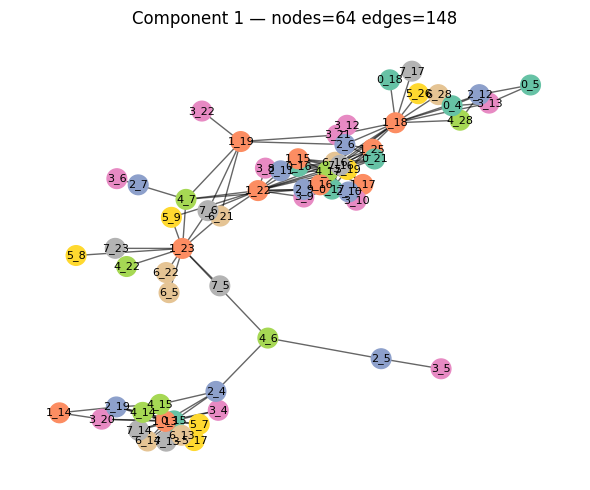

Plotting component 2: nodes=17 edges=32 -> graphs/components_sns/G-merged-comp-002-n17-e32.png


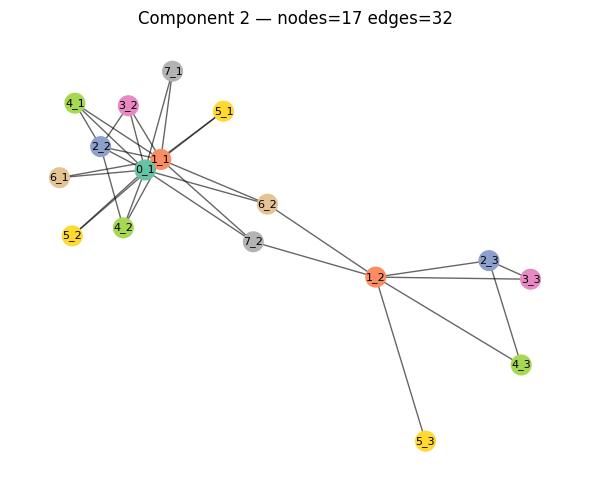

Plotting component 3: nodes=10 edges=28 -> graphs/components_sns/G-merged-comp-003-n10-e28.png


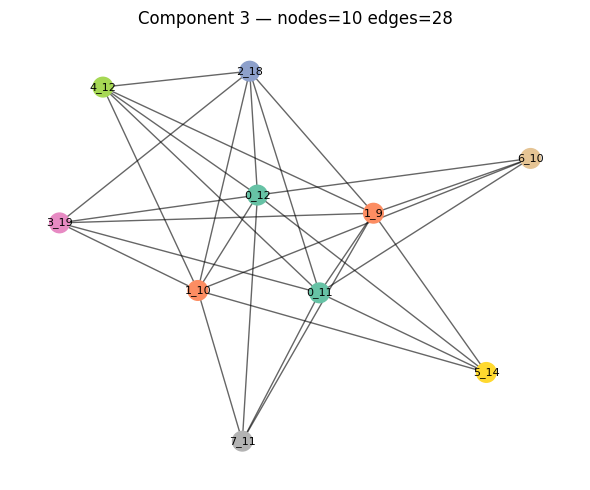

Plotting component 4: nodes=10 edges=17 -> graphs/components_sns/G-merged-comp-004-n10-e17.png


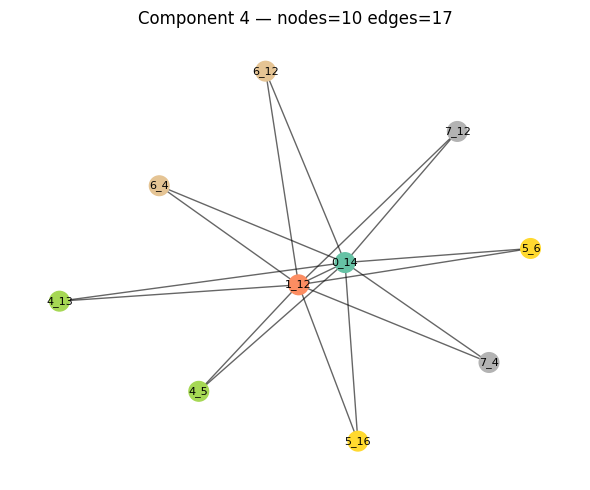

Plotting component 5: nodes=8 edges=15 -> graphs/components_sns/G-merged-comp-005-n8-e15.png


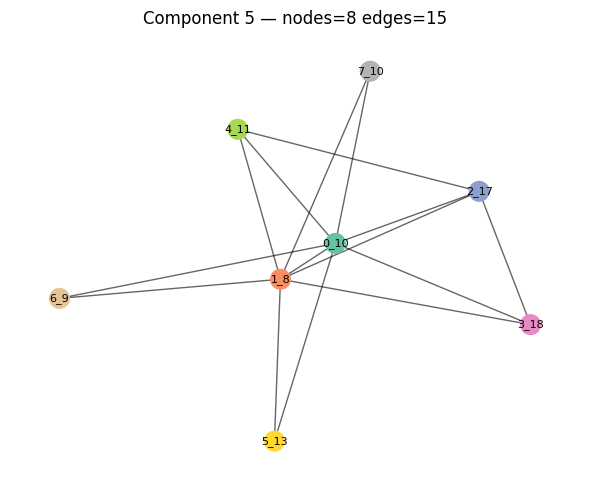

Plotting component 6: nodes=8 edges=15 -> graphs/components_sns/G-merged-comp-006-n8-e15.png


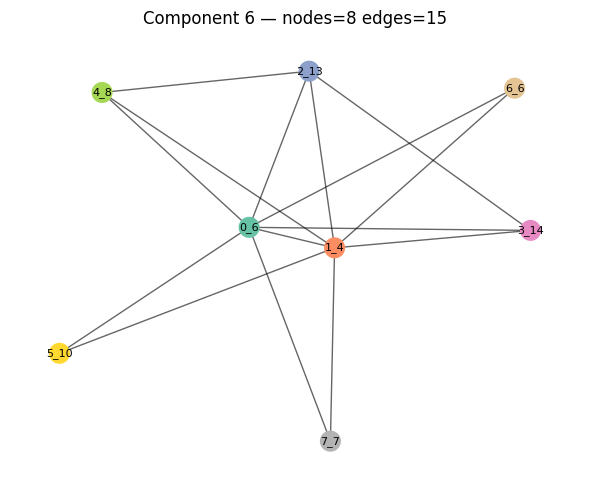

Plotting component 7: nodes=8 edges=15 -> graphs/components_sns/G-merged-comp-007-n8-e15.png


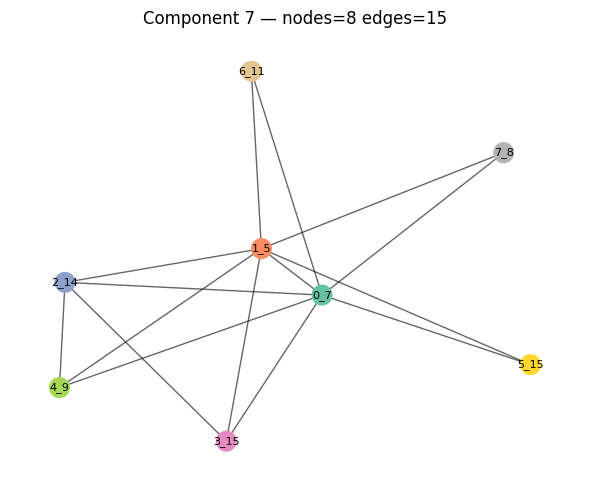

Plotting component 8: nodes=8 edges=15 -> graphs/components_sns/G-merged-comp-008-n8-e15.png


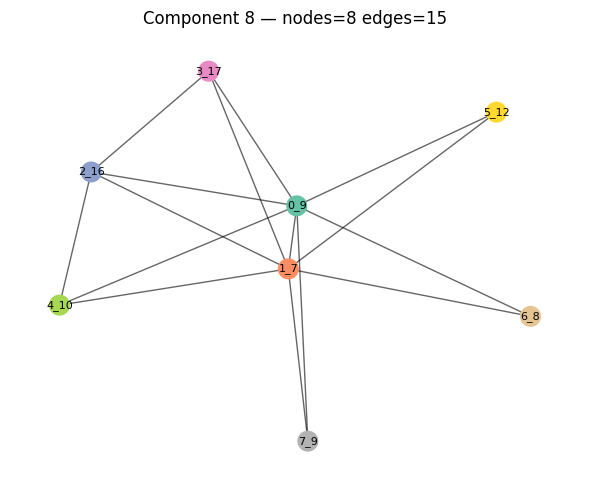

Plotting component 9: nodes=7 edges=13 -> graphs/components_sns/G-merged-comp-009-n7-e13.png


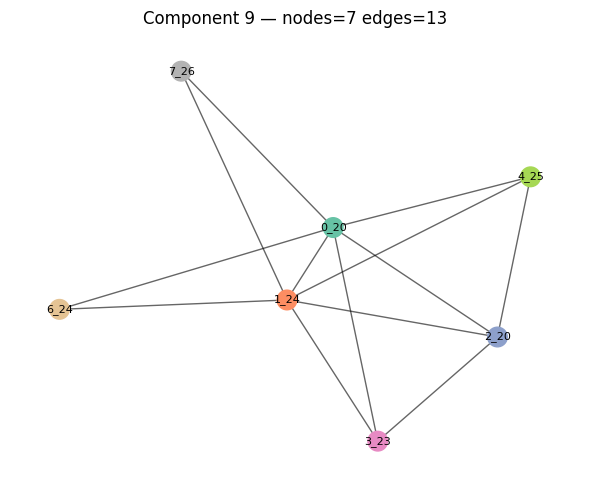

Plotting component 10: nodes=6 edges=9 -> graphs/components_sns/G-merged-comp-010-n6-e9.png


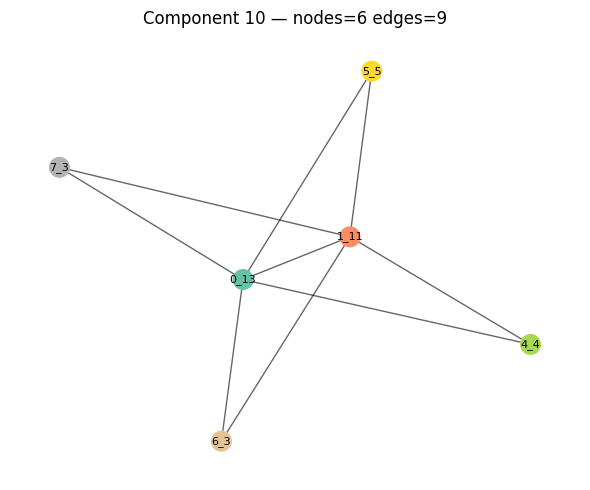

Plotting component 11: nodes=6 edges=5 -> graphs/components_sns/G-merged-comp-011-n6-e5.png


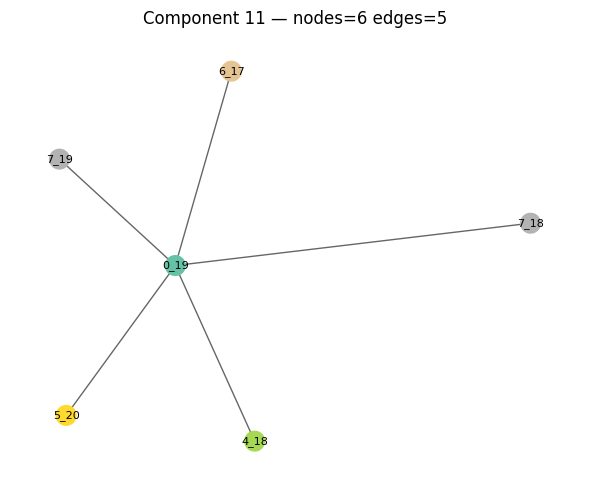

Plotting component 12: nodes=4 edges=4 -> graphs/components_sns/G-merged-comp-012-n4-e4.png


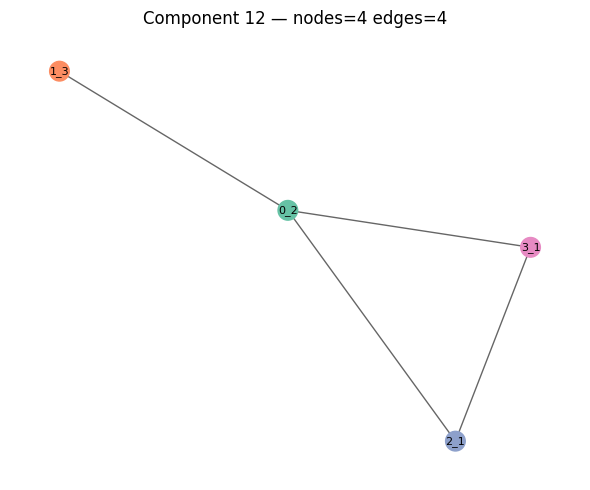

Plotting component 13: nodes=4 edges=6 -> graphs/components_sns/G-merged-comp-013-n4-e6.png


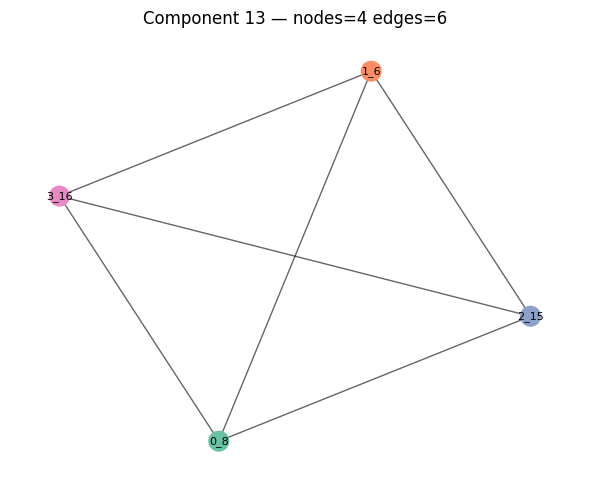

Plotting component 14: nodes=4 edges=5 -> graphs/components_sns/G-merged-comp-014-n4-e5.png


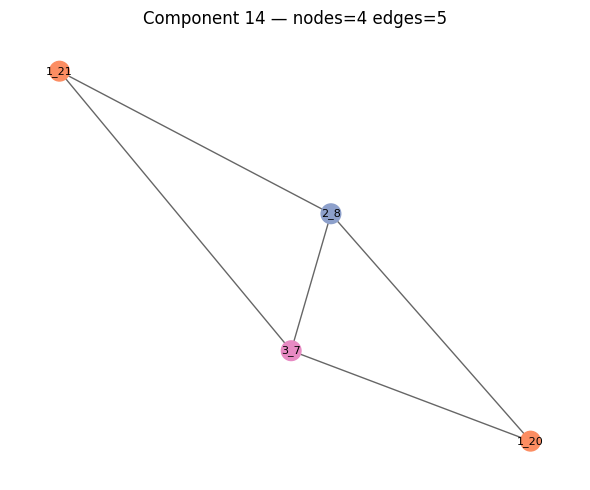

Saved 14 component images into graphs/components_sns


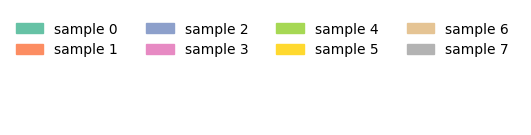

In [1]:
# Notebook cell: use seaborn palette for colors and visualize connected components separately
import os
import math
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import colors as mcolors
import seaborn as sns

# Параметры
graphs_dir = "graphs"
merged_edges_path = os.path.join(graphs_dir, "G-merged.tsv")
components_dir = os.path.join(graphs_dir, "components_sns")
os.makedirs(components_dir, exist_ok=True)

# Настройки визуализации
seed = 42
min_nodes = 1        # минимальный размер компоненты для визуализации
max_plots = None     # если задать int, будет отрисовано не больше первых max_plots компонентов
palette_name = "Set2"   # можно поменять: "tab20", "colorblind", "Set2" и т.д.
n_colors = 8             # ожидаем префиксы 0..7

# 1) Создать color_map из seaborn
pal = sns.color_palette(palette_name, n_colors=n_colors)
# color_map = {i: mcolors.to_hex(pal[i]) for i in range(n_colors)}
# default_color = '#7f7f7f'
pal = sns.color_palette("Set2", 8)   # можно поменять на "tab20", "colorblind", "Set2" и т.д.
color_map = {i: mcolors.to_hex(pal[i]) for i in range(8)}
default_color = '#7f7f7f'

print("Palette used:", palette_name, " ->", color_map)

# 2) Подготовить / загрузить граф G (если G нет в окружении, загрузим из TSV)
try:
    G  # use existing in-memory graph if present
    print("Using existing graph object G from environment.")
except NameError:
    if not os.path.exists(merged_edges_path):
        raise FileNotFoundError(f"Не найден {merged_edges_path}. Сначала соберите merged edges.")
    edges_agg = pd.read_csv(merged_edges_path, sep='\t')
    # Ensure columns names
    if 'source' not in edges_agg.columns or 'target' not in edges_agg.columns:
        raise ValueError("Merged TSV must contain 'source' and 'target' columns.")
    # Build graph with count/weight if available
    if 'count' in edges_agg.columns:
        G = nx.Graph()
        for _, r in edges_agg.iterrows():
            s = str(r['source'])
            t = str(r['target'])
            w = int(r['count'])
            if G.has_edge(s, t):
                G[s][t]['count'] += w
                G[s][t]['weight'] += w
            else:
                G.add_edge(s, t, count=w, weight=w)
    else:
        G = nx.from_pandas_edgelist(edges_agg, source='source', target='target')
    print(f"Loaded graph: nodes={G.number_of_nodes()}, edges={G.number_of_edges()}")

# 3) Определим side (префикс числа перед '_') для каждой вершины
node_side = {}
for n in G.nodes():
    parts = str(n).split('_', 1)
    try:
        node_side[n] = int(parts[0])
    except Exception:
        node_side[n] = None

# 4) Найдём компоненты и отсортируем по размеру (убывание)
components = sorted(nx.connected_components(G), key=lambda s: -len(s))
n_comp = len(components)
print(f"Found {n_comp} connected components (sorted by size)")

# 5) Функция для отрисовки одной компоненты
def plot_and_save_component(subG, comp_idx, out_png, figsize=(6,5)):
    deg = dict(subG.degree(weight='count'))  # weight-aware degree
    # цвета и размеры узлов
    node_colors = [ color_map.get(node_side.get(n), default_color) for n in subG.nodes() ]
    node_sizes = [ max(120, 200 + deg.get(n,0) * 30) for n in subG.nodes() ]
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(subG, seed=seed)  # reproducible layout
    node_sizes = 200
    nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=node_sizes)
    nx.draw_networkx_edges(subG, pos, alpha=0.6)
    nx.draw_networkx_labels(subG, pos, font_size=8)
    plt.title(f"Component {comp_idx} — nodes={subG.number_of_nodes()} edges={subG.number_of_edges()}")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(out_png, dpi=200)
    plt.show()
    plt.close()

# 6) Визуализируем компоненты по-отдельности
plots_done = 0
for i, comp_nodes in enumerate(components, start=1):
    if len(comp_nodes) < min_nodes:
        continue
    if (max_plots is not None) and (plots_done >= max_plots):
        break
    subG = G.subgraph(comp_nodes).copy()
    png_path = os.path.join(components_dir, f"G-merged-comp-{i:03d}-n{len(subG)}-e{subG.number_of_edges()}.png")
    print(f"Plotting component {i}: nodes={len(subG)} edges={subG.number_of_edges()} -> {png_path}")
    plot_and_save_component(subG, i, png_path, figsize=(6,5))
    plots_done += 1

print(f"Saved {plots_done} component images into {components_dir}")

# 7) Легенда палитры (покажем отдельно)
legend_handles = [Patch(color=color_map[k], label=f"sample {k}") for k in sorted(color_map.keys())]
plt.figure(figsize=(4,1.5))
plt.legend(handles=legend_handles, ncol=4, frameon=False)
plt.axis('off')
plt.show()
